In [1]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv

# Load from env
load_dotenv()

model = init_chat_model("gpt-4o-mini")

In [9]:
from pathlib import Path
import sys
# append dev directory to sys.path
sys.path.append(str(Path.cwd().parent / "agent"))

In [ ]:

# Import the data exploration agent
from data_exploration_subagent import build_agent as build_data_exploration_agent
from langchain.tools import tool

# Build the data exploration agent
data_exploration_agent = build_data_exploration_agent()

# Wrap data_exploration_agent as a tool
@tool("data_exploration_agent", description="Use this agent to explore and query the art database. Provide a natural language question about the art data.")
def call_data_exploration_agent(query: str) -> str:
    """
    Call the data exploration agent to answer questions about the art database.
    
    Args:
        query: A natural language question about the art data
        
    Returns:
        The response from the data exploration agent
    """
    result = data_exploration_agent.invoke(
        {"messages": [{"role": "user", "content": query}]}
    )
    return result["messages"][-1].content

In [19]:
from typing import Literal
from langgraph.graph import END, MessagesState
from langchain_core.messages import AIMessage, ToolMessage

# Node: Process user query with main agent
main_agent_system_prompt = """
You are a helpful assistant designed to answer questions about art data.
You have access to a specialized data exploration agent that can query the art database.

When users ask questions about the art data, use the data_exploration_agent tool to find the answers.
You can ask the agent multi-step questions and use the results to provide comprehensive responses.
"""


def process_query(state: MessagesState):
    """Process user query with the main agent."""
    system_message = {
        "role": "system",
        "content": main_agent_system_prompt,
    }
    llm_with_tools = model.bind_tools([call_data_exploration_agent])
    response = llm_with_tools.invoke([system_message] + state["messages"])
    
    return {"messages": [response]}


# Node: Call data exploration agent
def call_agent(state: MessagesState):
    """Call the data exploration agent tool."""
    tool_call = state["messages"][-1].tool_calls[0]
    result = call_data_exploration_agent.invoke(tool_call["args"]["query"])
    
    tool_message = ToolMessage(
        content=result,
        tool_call_id=tool_call["id"],
        name="data_exploration_agent",
    )
    
    return {"messages": [tool_message]}


# Conditional edge function
def should_continue(state: MessagesState) -> Literal[END, "call_agent"]:
    """Determine if we should call the agent or end."""
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "call_agent"


In [20]:
from langgraph.graph import START, StateGraph

# Build the main agent graph
def build_main_agent():
    """Build the main agent graph with data exploration agent as subagent."""
    builder = StateGraph(MessagesState)
    builder.add_node("process_query", process_query)
    builder.add_node("call_agent", call_agent)
    
    builder.add_edge(START, "process_query")
    builder.add_conditional_edges(
        "process_query",
        should_continue,
    )
    builder.add_edge("call_agent", "process_query")
    
    return builder.compile()


# Initialize the main agent
main_agent = build_main_agent()

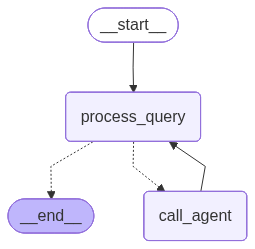

In [21]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(main_agent.get_graph().draw_mermaid_png()))

In [22]:
questions = [
    "Which genre has the oldest painting?",
    # "How many paintings are there from the Renaissance period?",
    # "What is the most common art style in the database?",
]

for question in questions:
    print(f"\nQuestion: {question}")
    print("-" * 50)
    
    for step in main_agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        stream_mode="values",
    ):
        step["messages"][-1].pretty_print()


Question: Which genre has the oldest painting?
--------------------------------------------------
================================ Human Message =================================

Which genre has the oldest painting?
================================== Ai Message ==================================
Tool Calls:
  data_exploration_agent (call_dPS6xUU15gxX2sdHIfhjDCJL)
 Call ID: call_dPS6xUU15gxX2sdHIfhjDCJL
  Args:
    query: What is the genre of the oldest painting in the art database?
================================= Tool Message =================================
Name: data_exploration_agent

The genre of the oldest painting in the art database is "religious art."
================================== Ai Message ==================================

The genre of the oldest painting in the art database is "religious art."
